### QuantGAN model

GAN은 stochastic process를 넘을 수 있을까?

In [1]:
import pandas as pd
import numpy as np

from scipy.optimize import fmin
from scipy.special import lambertw
from scipy.stats import kurtosis, norm

import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm
import yfinance as yf
import random

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
random.seed(42)
torch.manual_seed(42)

In [2]:
x = torch.ones(1, device = device)
print(x)

tensor([1.], device='mps:0')


In [3]:
sp500 = yf.download('^GSPC','2015-01-01','2024-03-01')

[*********************100%%**********************]  1 of 1 completed


#### Preprocessing

In [4]:
sp500log = np.log(sp500["Close"] / sp500["Close"].shift(1)).dropna()

<Axes: xlabel='Date'>

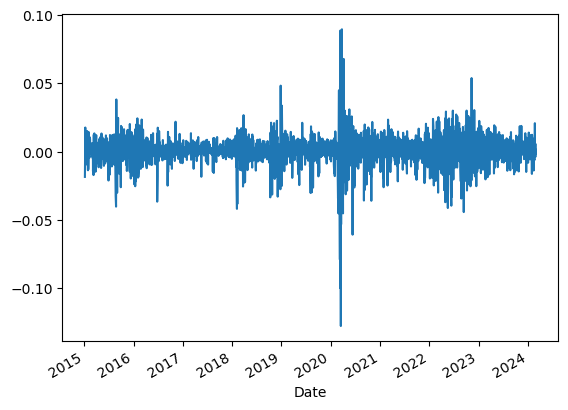

In [5]:
sp500log.plot()

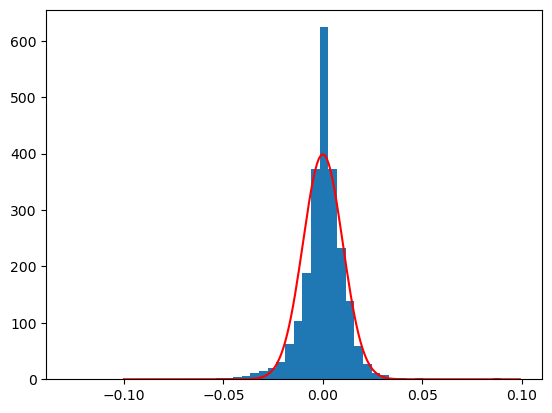

In [6]:
plt.hist(sp500log, bins = 50)
x_axis = np.arange(-0.1, 0.1, 0.001)
plt.plot(x_axis, norm.pdf(x_axis, 0, 0.01) * 10, color= 'r')
plt.show()

#### re-normalization

In [7]:
def delta_init(z):
    k = kurtosis(z, fisher=False, bias=False)
    if k < 166. / 62.:
        return 0.01
    return np.clip(1. / 66 * (np.sqrt(66 * k - 162.) - 6.), 0.01, 0.48)

def delta_gmm(z):
    delta = delta_init(z)

    def iter(q):
        u = W_delta(z, np.exp(q))
        if not np.all(np.isfinite(u)):
            return 0.
        k = kurtosis(u, fisher=True, bias=False)**2
        if not np.isfinite(k) or k > 1e10:
            return 1e10
        return k

    res = fmin(iter, np.log(delta), disp=0)
    return np.around(np.exp(res[-1]), 6)

def W_delta(z, delta):
    return np.sign(z) * np.sqrt(np.real(lambertw(delta * z ** 2)) / delta)

def W_params(z, params):
    return params[0] + params[1] * W_delta((z - params[0]) / params[1], params[2])

def inverse(z, params):
    return params[0] + params[1] * (z * np.exp(z * z * (params[2] * 0.5)))

def igmm(z, eps=1e-6, max_iter=100):
    delta = delta_init(z)
    params = [np.median(z), np.std(z) * (1. - 2. * delta) ** 0.75, delta]
    for k in range(max_iter):
        params_old = params
        u = (z - params[0]) / params[1]
        params[2] = delta_gmm(u)
        x = W_params(z, params)
        params[0], params[1] = np.mean(x), np.std(x)

        if np.linalg.norm(np.array(params) - np.array(params_old)) < eps:
            break
        if k == max_iter - 1:
            raise ValueError("Solution not found")

    return params

sp500log_mean = np.mean(sp500log)
sp500log_norm = sp500log - sp500log_mean
params = igmm(sp500log_norm)
sp500processed = W_delta((sp500log_norm - params[0]) / params[1], params[2])
sp500max = np.max(np.abs(sp500processed))
sp500processed /= sp500max

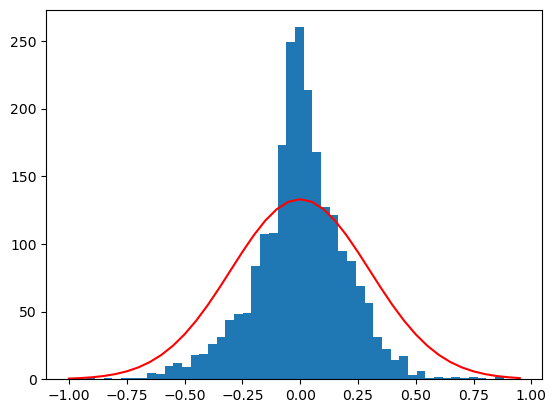

In [8]:
plt.hist(sp500processed, bins=50)
x_axis = np.arange(-1, 1, 0.05)
plt.plot(x_axis, norm.pdf(x_axis, 0, 0.3) * 100, color= 'r')
plt.show()

In [9]:
class SP500Dataset(Dataset):
    def __init__(self, data, window):
        self.data = data
        self.window = window

    def __getitem__(self, index):
        x = np.expand_dims(self.data[index:index+self.window], -1)
        return torch.from_numpy(x).float()

    def __len__(self):
        return len(self.data) - self.window

#### QuantGAN modeling

In [10]:
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_outputs, kernel_size, dilation):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_hidden, kernel_size, stride=1, dilation=dilation, padding='same')

        self.relu1 = nn.PReLU()
        self.conv2 = nn.Conv1d(n_hidden, n_outputs, kernel_size, stride=1, dilation=dilation, padding='same')
        self.relu2 = nn.PReLU()

        self.net = nn.Sequential(self.conv1, self.relu1, self.conv2, self.relu2)

        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None

        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return out + res

class TCN(nn.Module):
    def __init__(self, input_size, output_size, n_hidden=80):
        super(TCN, self).__init__()
        layers = []
        for i in range(7):
            num_inputs = input_size if i == 0 else n_hidden
            kernel_size = 2 if i > 0 else 1
            dilation = 2 * dilation if i > 1 else 1
            layers += [TemporalBlock(num_inputs, n_hidden, n_hidden, kernel_size, dilation)]
        self.conv = nn.Conv1d(n_hidden, output_size, 1)
        self.net = nn.Sequential(*layers)
        self.init_weights()

    def init_weights(self):
        self.conv.weight.data.normal_(0, 0.01)
    
    def forward(self, x):
        y1 = self.net(x.transpose(1, 2))
        return self.conv(y1).transpose(1, 2)

class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        self.net = TCN(input_size, output_size)

    def forward(self, x):
        return torch.tanh(self.net(x))

class Discriminator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Discriminator, self).__init__()
        self.net = TCN(input_size, output_size)

    def forward(self, x):
        return torch.sigmoid(self.net(x))

#### prepare and train GAN

In [11]:
import numpy as np

# Early stopping 관련 설정
patience = 15  # 성능이 개선되지 않는 에폭 수
min_loss_diff = 0.001  # 개선으로 간주되기 위한 최소 손실 감소량
best_loss = np.inf  # 최고 손실 초기화
trigger_times = 0  # Early stopping 트리거 카운터
clip_value = 0.01
lr = 0.0002
num_epochs = 100
nz = 3
batch_size = 30
seq_len = 127

netG = Generator(nz, 1).to(device)
netD = Discriminator(1, 1).to(device)
optD = optim.RMSprop(netD.parameters(), lr = lr)
optG = optim.RMSprop(netG.parameters(), lr = lr)

dataset = SP500Dataset(sp500processed, 127)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
t = tqdm(range(num_epochs))

for epoch in t:
    epoch_lossD = 0.0
    epoch_lossG = 0.0
    for i, data in enumerate(dataloader, 0):

        # Discriminator 학습
        netD.zero_grad()
        real = data.to(device)
        batch_size, seq_len = real.size(0), real.size(1)
        noise = torch.randn(batch_size, seq_len, nz, device=device)
        fake = netG(noise).detach()

        lossD = -torch.mean(netD(real)) + torch.mean(netD(fake))
        lossD.backward()
        optD.step()

        for p in netD.parameters():
            p.data.clamp_(-clip_value, clip_value)
  
        if i % 5 == 0:
            netG.zero_grad()
            lossG = -torch.mean(netD(netG(noise)))
            lossG.backward()
            optG.step()
        
        epoch_lossD += lossD.item()
        epoch_lossG += lossG.item()

    epoch_lossD /= len(dataloader)
    epoch_lossG /= len(dataloader)

    current_loss = epoch_lossD + epoch_lossG
    loss_diff = best_loss - current_loss
    if loss_diff > min_loss_diff:
        best_loss = current_loss
        trigger_times = 0
    else:
        trigger_times += 1

    # Early stopping 트리거 조건 만족 시 학습 종료
    if trigger_times >= patience:
        print("Early stopping at epoch %d" % epoch)
        break

    #Report metrics
    t.set_description('Loss_D: %.8f Loss_G: %.8f' % (epoch_lossD, epoch_lossG))
        
    # Checkpoint
    torch.save(netG, 'sp500_netG_epoch_%d.pth' % epoch)
    torch.save(netD, 'sp500_netD_epoch_%d.pth' % epoch)

  0%|          | 0/100 [00:00<?, ?it/s]/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_52h9q6gsr9/croot/pytorch-select_1707258249748/work/aten/src/ATen/native/Convolution.cpp:1041.)
  return F.conv1d(input, weight, bias, self.stride,
Loss_D: -0.00000869 Loss_G: -0.49996492:  29%|██▉       | 29/100 [01:41<04:07,  3.48s/it]

Early stopping at epoch 29


#### Probe generation

In [12]:
len_data = len(sp500processed)

In [13]:
noise = torch.randn(
    1, len_data, 3, device = device 
)
fake = netG(noise).detach().cpu().reshape(len_data).numpy()

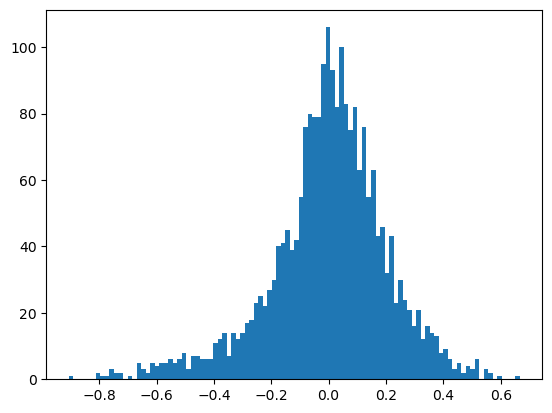

In [14]:
plt.hist(fake, bins = 100)
plt.show()

In [15]:
sp500fake = inverse(fake * sp500max, params = params)

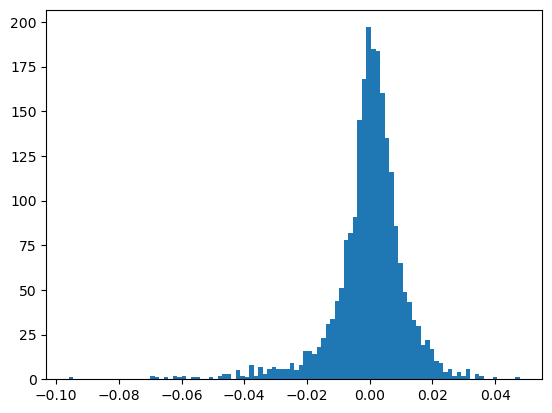

In [16]:
plt.hist(sp500fake, bins=100)
plt.show()

In [17]:
def generate_fakes(n=1, cumsum=True):
    fakes = []
    for i in range(n):
        noise = torch.randn(1, len_data, 3, device=device)
        fake = netG(noise).detach().cpu().reshape(len_data).numpy()
        sp500fake = inverse(fake * sp500max, params) + sp500log_mean
        fakes.append(sp500fake)
    if n > 1:
        if not cumsum:
            return pd.DataFrame(fakes).T
        fakes_df = pd.DataFrame(fakes).T.cumsum()
        return fakes_df
    elif not cumsum:
        return sp500fake
    return sp500fake.cumsum()

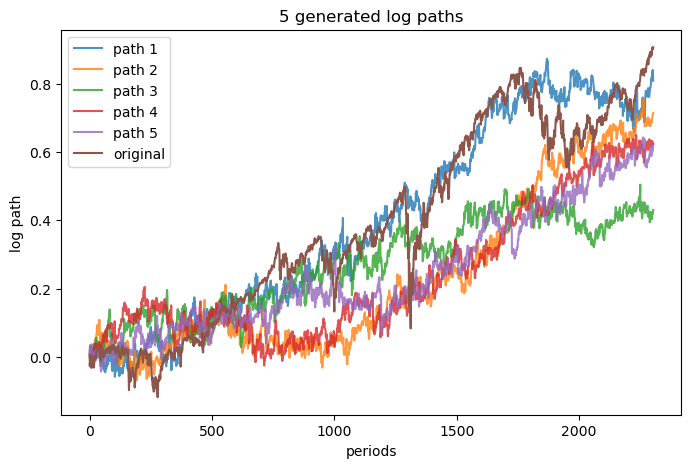

In [18]:
plt.figure(figsize = (8, 5))
plt.plot(generate_fakes(5), alpha = 0.8)
plt.plot(sp500log.cumsum().values, alpha = 1)
plt.legend([
    'path ' + str(i) for i in range(1, 6)
] + ['original'])
plt.grid(False)
plt.xlabel('periods')
plt.ylabel('log path')
plt.title('5 generated log paths')
plt.show()

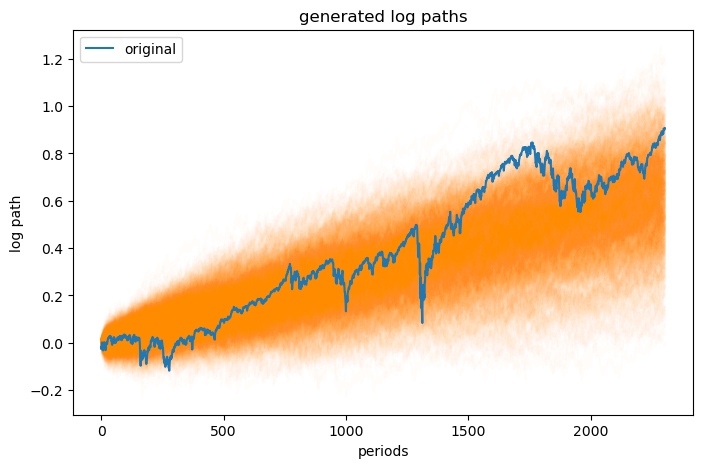

In [19]:
plt.figure(figsize = (8, 5))
plt.plot(generate_fakes(1000), alpha = 0.02, color = 'darkorange')
plt.plot(sp500log.cumsum().values, alpha = 1, label = 'original')
plt.grid(False)
plt.legend()
plt.xlabel('periods')
plt.ylabel('log path')
plt.title('generated log paths')
plt.show()

<Axes: xlabel='Date'>

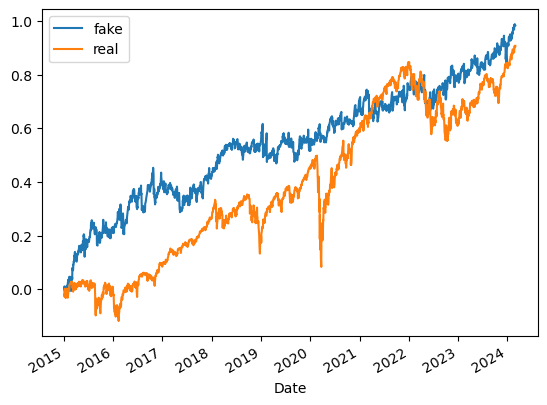

In [20]:
comp_df = pd.DataFrame(
    {'fake': generate_fakes(), 'real': sp500log.cumsum()},
    index = sp500log.index
)
comp_df.plot()

### Bayesian Update

GAN에서 생성한 모형을 Prior 경로로 가정하고, Observation 경로를 original data로 두면 Posterior는 시장 상황에 더욱 알맞는 경로를 추정하지 않을까?

In [21]:
posterior = pd.DataFrame(
    (sp500log.values * generate_fakes(1000).T).T.values,
    index = sp500log.index,
    columns = ['path_' + str(i) for i in range(1, 1001)]
)

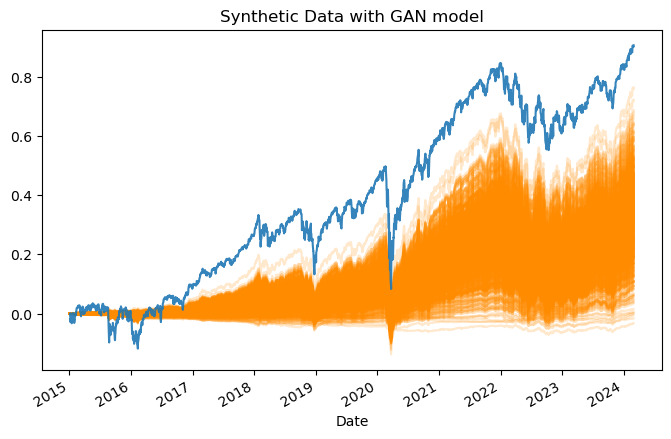

In [22]:
posterior.cumsum().plot(
    color = 'darkorange', 
    alpha = 0.2, 
    legend = False, 
    figsize = (8, 5)
)
sp500log.cumsum().plot(
    alpha = 0.9, 
    legend = False
)
plt.title('Synthetic Data with GAN model')
plt.show()

### Stochastic Process와 비교

In [23]:
from FinancialMachineLearning.generator.stochastic_process import *

In [31]:
sp500log.std()

0.01151646309364279

In [69]:
simulation = MonteCarloSimulation(
    interest_rate = 0.03,    
    initial_price = sp500.Close[0],     
    maturity = 1,          
    sigma = 0.01151646309364279,           
    dividend_yield = 0.00,  
    nObs = 1000,           
    slices = len_data - 1,       
    random_state = 42 
)

In [70]:
gbm_path = pd.DataFrame(
    simulation.geometric_brownian_motion().T, 
    index = sp500log.index
)

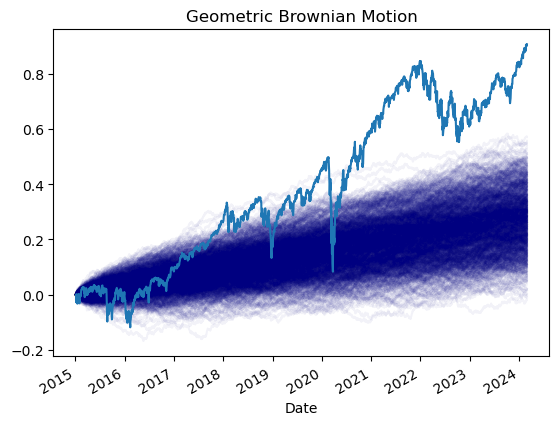

In [86]:
(np.log(gbm_path / gbm_path.shift()).cumsum() * 9.2).plot(
    legend = False, color = 'navy', alpha = 0.05
)
plt.plot(sp500log.cumsum(), alpha = 1, label = 'original')
plt.title('Geometric Brownian Motion')
plt.show()

In [105]:
ou_path = pd.DataFrame(
    simulation.ornstein_uhlenbeck(kappa = 0.05, theta = sp500.Close[-1], sigma = 50).T, 
    index = sp500log.index
)

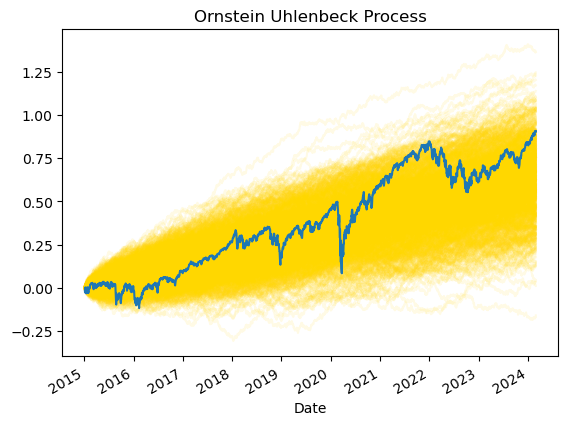

In [111]:
(np.log(ou_path / ou_path.shift()).cumsum() * 9.2).plot(
    legend = False, color = 'gold', alpha = 0.1
)
plt.plot(sp500log.cumsum(), alpha = 1, label = 'original')
plt.title('Ornstein Uhlenbeck Process')
plt.show()

In [138]:
jd_path = pd.DataFrame(
    simulation.jump_diffusion_model(jump_intensity = 0.3, jump_mean = 13.186, jump_std = 0.5).T, 
    index = sp500log.index
)

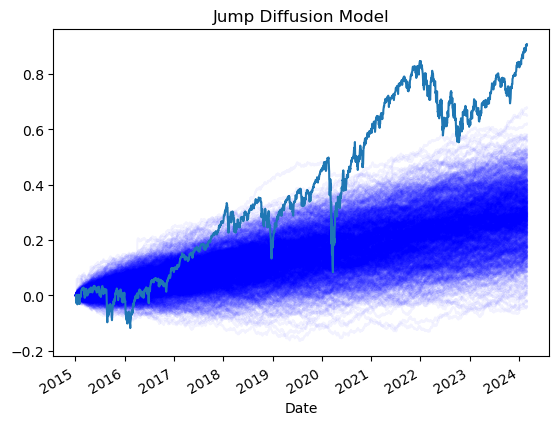

In [139]:
(np.log(jd_path / jd_path.shift()).cumsum() * 9.2).plot(
    legend = False, color = 'blue', alpha = 0.05
)
plt.plot(sp500log.cumsum(), alpha = 1, label = 'original')
plt.title('Jump Diffusion Model')
plt.show()

In [140]:
gan_model = pd.DataFrame(
    generate_fakes(1000).values, index = sp500log.index
)

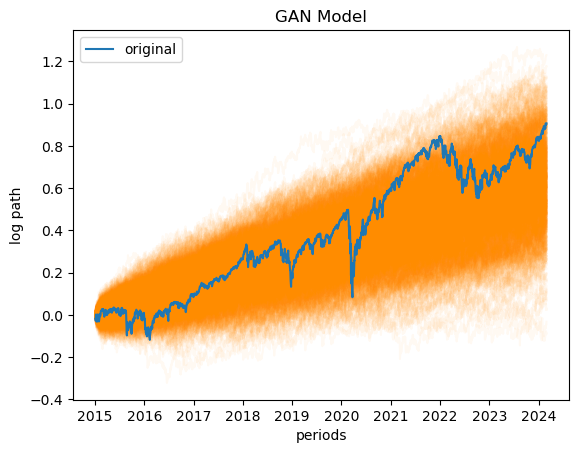

In [141]:
plt.plot(gan_model, alpha = 0.05, color = 'darkorange')
plt.plot(sp500log.cumsum(), alpha = 1, label = 'original')
plt.grid(False)
plt.legend()
plt.xlabel('periods')
plt.ylabel('log path')
plt.title('GAN Model')
plt.show()

#### Conclusion

GAN을 통한 Synthetic Process Generating은 parameter를 추정할 필요가 없고 유사한 stochastic process를 생성한다는 점에서 매우 유용한 것처럼 보인다.